# Measurement Error Mitigation on Quantum Inspire
Pieter Eendebak <pieter.eendebak@tno.nl><br/>

For more details see [Qiskit textbook on measurement error mitigation](https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html) and [Mitiq documentation](https://mitiq.readthedocs.io/en/stable/readme.html).

For quantum devices, in particular spin-qubits, the measurement error is significant with respect to other sources of errors. We can reduce the effect of measurement errors using measurement error mitigation. This is particularly important when different qubits have different readout fidelities or when there is a cross-talk between the qubits readouts.

To install the required dependencies for this notebook run: `pip install qiskit rich quantuminspire requests`

In [1]:
import logging

import numpy as np
import qiskit
import requests
from qiskit import Aer, QuantumCircuit, QuantumRegister, assemble, execute, transpile
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter, complete_meas_cal
from qiskit.providers.aer.noise import NoiseModel, ReadoutError
from qiskit.providers.aer.noise.errors import depolarizing_error, pauli_error
from qiskit.visualization import plot_histogram
from quantuminspire.api import QuantumInspireAPI
from quantuminspire.credentials import get_authentication
from quantuminspire.qiskit import QI


def get_qi_calibration_from_qiskit_result(qi_job, api, authentication) -> dict:
    """ Return calibration data from a QI job """
    project = api.get_project(qi_job.job_id())
    # NOTE: due to limited capabilties of the QI framework this is the latest job, perhaps not the actual job
    job = qi_job.get_jobs()[0]
    result = api.get_result_from_job(job["id"])
    c = result["calibration"]
    result = requests.get(c, auth=authentication)
    calibration = result.json()
    return calibration

## Introduction

We will measure a Bell state, first without error mitigation, and then with error mitigation. We perform the calculations on real hardware (or on a simulator when the hardware is not available).

In [2]:
def spin_2_noise_model(p: float = 0.01):
    """ Define noise model representation for Spin-2 """
    noise_model = NoiseModel()
    error_gate = pauli_error([("X", p), ("I", 1 - p)])

    noise_model.add_all_qubit_quantum_error(error_gate, ["u1", "u2", "u3", "rx", "ry", "x", "y"])

    read_err = ReadoutError([[0.9, 0.1], [0.2, 0.8]])
    noise_model.add_readout_error(read_err, [0])
    read_err = ReadoutError([[0.7, 0.3], [0.25, 0.75]])
    noise_model.add_readout_error(read_err, [1])
    return noise_model


noise_model_spin2 = spin_2_noise_model()

## Set up connection to QI

We expect the user to have set up the token authentication as described [here](https://github.com/qutech-delft/quantuminspire#configure-your-token-credentials-for-quantum-inspire) in order to be able to access the Spin-2 backend in the following cells.

In [3]:
try:
    authentication = get_authentication()
    qi_api = QuantumInspireAPI(authentication=authentication)
    QI.set_authentication(authentication)
    qi_backend = QI.get_backend("Spin-2")
except:
    print("QI connection not available, fall-back to simulation.")
    qi_api = None
    qi_backend = None

Enter email:
example@email.com
Enter password
········
QI connection not available, fall-back to simulation.


In [4]:
def execute_circuit_spin2(qc, qi_backend, shots=2048):
    """  Execute circuit on Spin-2 with fall-back to simulation """
    try:
        logging.info(f"execute_circuit_spin2: run on {qi_backend}")
        qi_job = execute(qc, backend=qi_backend, shots=shots)

        result = qi_job.result()
    except Exception as ex:
        print(f"Failed to run on backend {qi_backend}: {ex}, fall-back to simulation")
        logging.info("execute_circuit_spin2: fallback to simulation")
        backend = Aer.get_backend("qasm_simulator")
        result = backend.run(qc, shots=shots, noise_model=noise_model_spin2).result()
        qi_job = None
    return result, qi_job

## Error mitigation for Spin-2

Run error mitigation test on a Bell state $(\left|00\right\rangle+\left|11\right\rangle)/\sqrt{2}$.

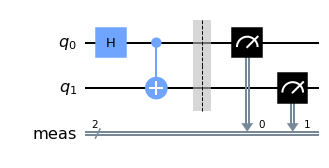

Failed to run on backend None: "Invalid backend type <class 'NoneType'>", fall-back to simulation
{'11': 655, '00': 700, '01': 272, '10': 421}


In [5]:
qc = QuantumCircuit(2, name="Bell state")
qc.h(0)
qc.cx(0, 1)
qc.measure_all()
display(qc.draw(output="mpl"))

bell_measurement_result, qi_job = execute_circuit_spin2(qc, qi_backend)
noisy_counts = bell_measurement_result.get_counts()

print(noisy_counts)

In [6]:
if qi_job:
    cr = get_qi_calibration_from_qiskit_result(qi_job, qi_api, authentication)

    measurement_error_results = cr["parameters"]["system"]["readout_error_calibration"]["qiskit_result"]
    measurement_error_results = qiskit.result.Result.from_dict(measurement_error_results)

    timestamp = cr["parameters"]["system"]["readout_error_calibration"]["timestamp"]
    print(f"Using calibration of {timestamp}")
else:
    measurement_error_results = np.array(
        [
            [0.7421875, 0.12890625, 0.0, 0.0390625],
            [0.11328125, 0.62890625, 0.0, 0.13671875],
            [0.140625, 0.05859375, 1.0, 0.11328125],
            [0.00390625, 0.18359375, 0.0, 0.7109375],
        ]
    )

In Qiskit we mitigate the noise by creating a measurement filter object. Then, taking the results from above, we use this to calculate a mitigated set of counts.

In [7]:
if isinstance(measurement_error_results, np.ndarray):
    meas_fitter = CompleteMeasFitter(None, state_labels=["00", "01", "10", "11"])
    meas_fitter.cal_matrix = measurement_error_results
else:
    state_labels = ["00", "01", "10", "11"]
    meas_fitter = CompleteMeasFitter(measurement_error_results, state_labels, circlabel="")

In [8]:
meas_filter = meas_fitter.filter

# Results with error mitigation
mitigated_results = meas_filter.apply(bell_measurement_result)
mitigated_counts = mitigated_results.get_counts()

To see the results most clearly, let's plot both the noisy and mitigated results.

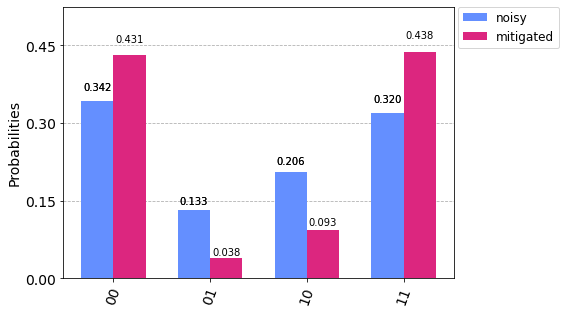

In [9]:
plot_histogram([noisy_counts, mitigated_counts], legend=["noisy", "mitigated"])

Note that the skew between the two qubits has reduced significantly.

## Measurement of the error matrix

The process of measurement error mitigation can also be done using the existing tools from Qiskit. This handles the collection of data for the basis states, the construction of the matrices, and the calculation of the inverse. The latter can be done using the pseudoinverse, as we saw above. However, the default is an even more sophisticated method which is using least-squares fitting.

As an example, let's stick with doing error mitigation for a pair of qubits. For this, we define a two-qubit quantum register, and feed it into the function `complete_meas_cal`.

In [10]:
qr = QuantumRegister(2)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel="")

This creates a set of circuits that are used to take measurements for each of the four basis states of two qubits: $\left|00\right\rangle$, $\left|01\right\rangle$, $\left|10\right\rangle$ and $\left|11\right\rangle$.

Circuit cal_00


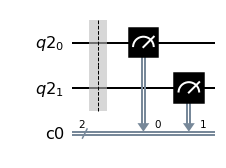

Circuit cal_01


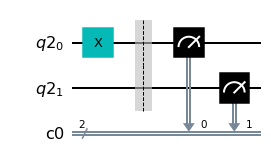

Circuit cal_10


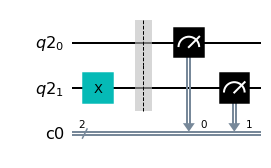

Circuit cal_11


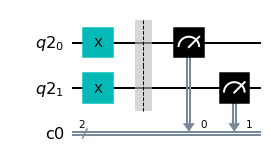

In [11]:
for circuit in meas_calibs:
    print(f"Circuit {circuit.name}")
    display(circuit.draw(output="mpl"))

Let's now run these circuits.

In [12]:
cal_results = [execute_circuit_spin2(qc, qi_backend, shots=2048)[0] for qc in meas_calibs]

Failed to run on backend None: "Invalid backend type <class 'NoneType'>", fall-back to simulation
Failed to run on backend None: "Invalid backend type <class 'NoneType'>", fall-back to simulation
Failed to run on backend None: "Invalid backend type <class 'NoneType'>", fall-back to simulation
Failed to run on backend None: "Invalid backend type <class 'NoneType'>", fall-back to simulation


With the results we can construct the calibration matrix, which we have been calling $M$.

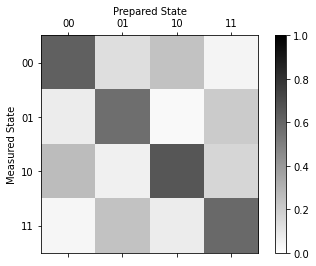

In [13]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel="")
meas_fitter.cal_matrix

meas_fitter.plot_calibration()

In [14]:
print(f"Readout fidelity of our system: {meas_fitter.readout_fidelity():.2f}")

Readout fidelity of our system: 0.61


## Readout rebalancing

Note that the error mitigation protocol described above does not change the execution of the quantum algorithms. There is another mitigation technique called readout rebalancing that does change the algorithms executed. Readout rebalancing places strategic X gates before measurements in order to reduce the variability in the measurement results. 
Check out the paper [Readout Rebalancing for Near Term Quantum Computers](https://arxiv.org/pdf/2010.07496.pdf) and the [corresponding notebook](https://github.com/LBNL-HEP-QIS/ReadoutRebalancing/blob/master/TestRebalancing.ipynb) for more information.